# Look at Tycho-2 - Gaia catalog (TGAS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.stats import gaussian_kde, truncnorm
from sklearn.neighbors import KernelDensity
import time

import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import parallax
from scipy.stats import norm, truncnorm, multivariate_normal
from numpy.random import normal
import const as c

import scipy.optimize as so
from matplotlib import font_manager

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Read in sample from TGAS table
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8'), \
     ('mu_ra_mu_dec_cov','<f8'),('mu_ra_plx_cov','<f8'),('mu_dec_plx_cov','<f8'),('d_Q','<f8'),('noise','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

                                                  # Gaia units
    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']                   # degrees
    tgas['dec'] = tgas_tmp['dec']                 # degrees
    tgas['mu_ra'] = tgas_tmp['pmra']              # mas/yr
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']    # mas/yr
    tgas['mu_dec'] = tgas_tmp['pmdec']            # mas/yr
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']  # mas/yr
    tgas['plx'] = tgas_tmp['parallax']            # mas
    tgas['plx_err'] = tgas_tmp['parallax_error']  # mas
    tgas['mu_ra_mu_dec_cov'] = tgas_tmp['pmra_pmdec_corr']*tgas_tmp['pmra_error']*tgas_tmp['pmdec_error']
    tgas['mu_ra_plx_cov'] = tgas_tmp['parallax_pmra_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmra_error']
    tgas['mu_dec_plx_cov'] = tgas_tmp['parallax_pmdec_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmdec_error']
    tgas['d_Q'] = tgas_tmp['astrometric_delta_q']
    tgas['noise'] = tgas_tmp['astrometric_excess_noise_sig']

    tgas_full = np.append(tgas_full, tgas)


../data/TGAS/TgasSource_000-000-000.csv


### Let's look at TGAS catalog quality

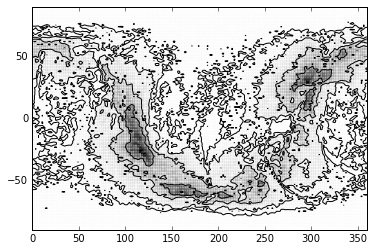

In [17]:
import corner

corner.hist2d(tgas_full['ra'], tgas_full['dec'], bins=150, plot_datapoints=False)

plt.show()

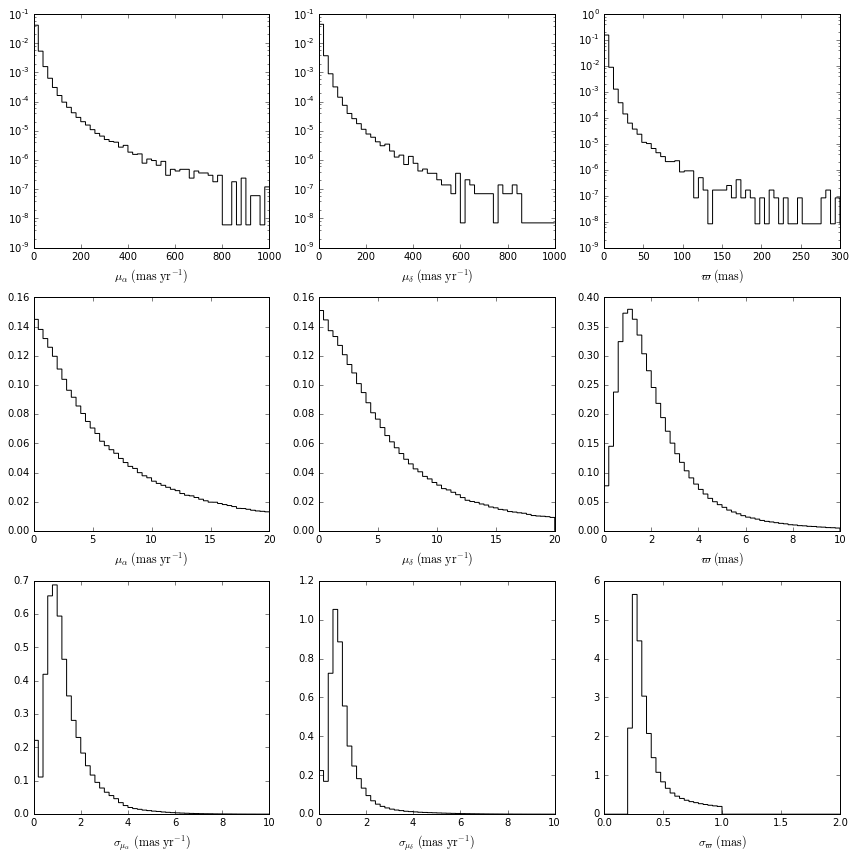

In [84]:
fig, ax = plt.subplots(3, 3, figsize=(12,12))

ax[0,0].hist(tgas_full['mu_ra'], histtype='step', color='k', bins=50, normed=True, range=(0,1000), log=True)
ax[0,1].hist(tgas_full['mu_dec'], histtype='step', color='k', bins=50, normed=True, range=(0,1000), log=True)
ax[0,2].hist(tgas_full['plx'], histtype='step', color='k', bins=50, normed=True, range=(0,300), log=True)
ax[0,0].set_xlabel(r'$\mu_{\alpha}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[0,1].set_xlabel(r'$\mu_{\delta}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[0,2].set_xlabel(r'$\varpi\ ({\rm mas})$', fontsize=12)

ax[1,0].hist(tgas_full['mu_ra'], histtype='step', color='k', bins=50, normed=True, range=(0,20))
ax[1,1].hist(tgas_full['mu_dec'], histtype='step', color='k', bins=50, normed=True, range=(0,20))
ax[1,2].hist(tgas_full['plx'], histtype='step', color='k', bins=50, normed=True, range=(0,10))
ax[1,0].set_xlabel(r'$\mu_{\alpha}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[1,1].set_xlabel(r'$\mu_{\delta}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[1,2].set_xlabel(r'$\varpi\ ({\rm mas})$', fontsize=12)

ax[2,0].hist(tgas_full['mu_ra_err'], histtype='step', color='k', bins=50, normed=True, range=(0,10))
ax[2,1].hist(tgas_full['mu_dec_err'], histtype='step', color='k', bins=50, normed=True, range=(0,10))
ax[2,2].hist(tgas_full['plx_err'], histtype='step', color='k', bins=50, normed=True, range=(0,2))
ax[2,0].set_xlabel(r'$\sigma_{\mu_{\alpha}}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[2,1].set_xlabel(r'$\sigma_{\mu_{\delta}}\ ({\rm mas\ yr}^{-1})$', fontsize=12)
ax[2,2].set_xlabel(r'$\sigma_{\varpi}\ ({\rm mas})$', fontsize=12)

plt.tight_layout()
plt.show()

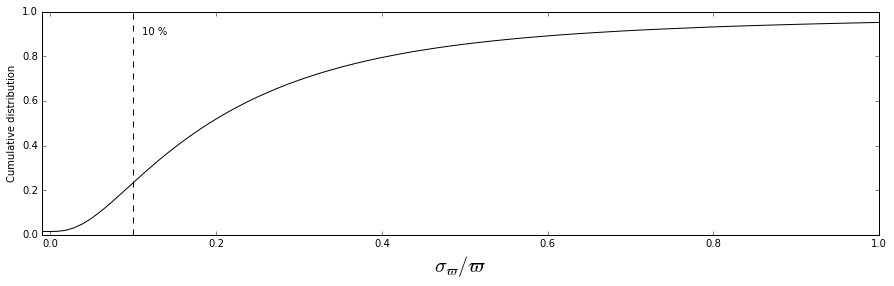

In [111]:
fig = plt.figure(figsize=(15,4))

# Cumulative distribution
plt.plot(np.sort(tgas_full['plx_err']/tgas_full['plx']), np.arange(len(tgas_full))/float(len(tgas_full)), color='k')

plt.xlabel(r'$\sigma_{\varpi} / \varpi$', fontsize=20)
plt.ylabel('Cumulative distribution')

plt.axvline(0.1, linestyle='dashed', color='k')
plt.text(0.11, 0.9, "10 %")

plt.xlim(-0.01, 1.0)

plt.show()

### Testing KDE from binaries

In [3]:
import sys
sys.path.append('../src')
import P_binary

start time: 1477657411.42
Generate binaries: 5.10915899277 seconds
Build tree: 0.14395904541 seconds
Histogram: 0.11735701561 seconds
Default gaussian_kde: 0.548930883408 seconds


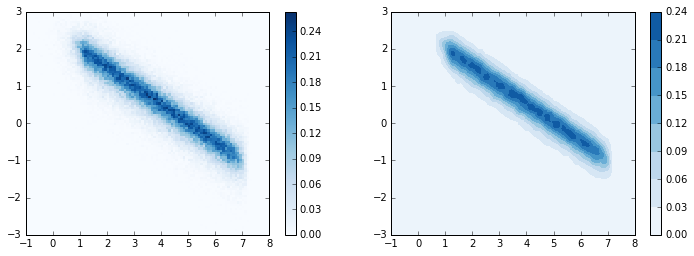

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

P_binary.binary_kde = None

start = time.time()
print "start time:", start

num_sys = 100000
P_binary.generate_binary_set(num_sys=num_sys)
mu_set = np.array([np.log10(P_binary.binary_set['proj_sep']), np.log10(P_binary.binary_set['delta_v_trans'])]).T

print "Generate binaries:", time.time()-start, "seconds"
start = time.time()

P_binary.get_P_binary(np.array([1.0, 1.0]), np.array([1.0, 0.9]))

print "Build tree:", time.time()-start, "seconds"
start = time.time()

nbins = 100
xmin, xmax = -1.0, 8.0
ymin, ymax = -3.0, 3.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T


pdf, xedges, yedges = np.histogram2d(np.log10(P_binary.binary_set["proj_sep"]), 
                                     np.log10(P_binary.binary_set["delta_v_trans"]), 
                                     normed=True,
                                     bins=[xbins,ybins])
im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues')
fig.colorbar(im, ax=ax[0])

print "Histogram:", time.time()-start, "seconds"
start = time.time()

P_binary.binary_kde = None
# kwargs = {'kernel':'tophat'}
# P_binary.binary_kde = KernelDensity(bandwidth=0.3, **kwargs)
# P_binary.binary_kde.fit( np.array([np.log10(P_binary.binary_set['proj_sep']), 
#                                    np.log10(P_binary.binary_set['delta_v_trans'])]).T )
Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten(), kde_method='sklearn')
#Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten(), kde_method='scipy')
Z = Z * 10**X.flatten() * 10**Y.flatten() * np.log(10.)**2
#im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues', extend='max')
im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', vmax=0.27)
#im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues')
fig.colorbar(im, ax=ax[1])

print "Default gaussian_kde:", time.time()-start, "seconds"
start = time.time()



plt.show()

In [6]:
P_binary.binary_kde = None
print P_binary.get_P_binary(1.0e5, 0.2)

[  6.45397404e-07]


/Library/Python/2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Test KDE method on parallax data

In [3]:
import sys
sys.path.append('../src')
import P_posterior
import parallax

0.01


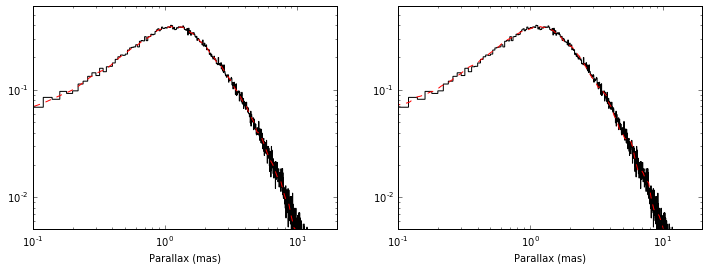

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

parallax.plx_kde = None
parallax.set_plx_kde(tgas_full, bandwidth=0.01, method='scipy_kde')
print parallax.plx_kde.covariance_factor()


xmin, xmax = 0.01, 100
x = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)
ax[0].hist(tgas_full['plx'], histtype='step', color='k', bins=10000, normed=True, range=(0,200))
ax[0].plot(x, parallax.get_plx_prior(x, method='scipy_kde'), color='r', linestyle='dashed')




parallax.plx_kde = None
parallax.set_plx_kde(tgas_full, bandwidth=0.3, method='sklearn_kde')

ax[1].hist(tgas_full['plx'], histtype='step', color='k', bins=10000, normed=True, range=(0,200))
ax[1].plot(x, parallax.get_plx_prior(x, method='sklearn_kde'), color='r', linestyle='dashed')


# Adjust all the plots
for a in ax:
    a.set_xscale('log')
    a.set_xlim(0.1,20)
    a.set_yscale('log')
    a.set_ylim(5.0e-3, 6.0e-1)
    a.set_xlabel('Parallax (mas)')

plt.show()

In [6]:
print parallax.plx_kde.bandwidth

0.1


### Now, let's test the KDE on the proper motion

In [3]:
import sys
sys.path.append('../src')
import P_random

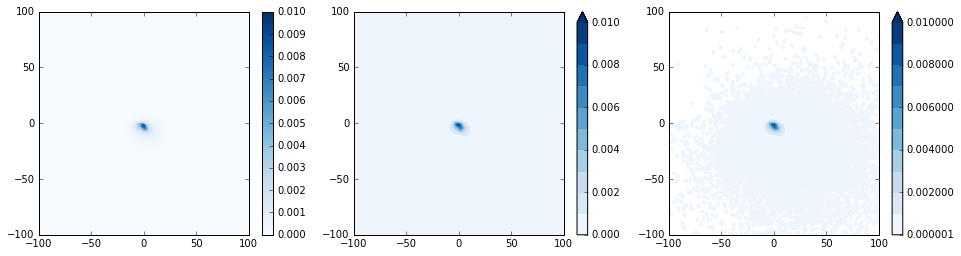

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

nbins = 200
xmin, xmax = -100.0, 100.0
ymin, ymax = -100.0, 100.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T

pdf, xedges, yedges = np.histogram2d(tgas_full['mu_ra'], 
                                     tgas_full['mu_dec'], 
                                     normed=True,
                                     bins=[xbins,ybins])

im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues', vmax=0.01)
fig.colorbar(im, ax=ax[0])


P_random.mu_kde = None
Z = P_random.get_sigma_mu(X.flatten(), Y.flatten(), catalog=tgas_full, method='sklearn_kde', bandwidth=0.5)
levels=[1.0e-10, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')
fig.colorbar(im, ax=ax[1])



P_random.mu_kde = None
Z = P_random.get_sigma_mu(X.flatten(), Y.flatten(), catalog=tgas_full, method='sklearn_kde', bandwidth=1.0)

levels=[1.1e-6, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
im = ax[2].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')
fig.colorbar(im, ax=ax[2])


for a in ax:
    a.set_xlim(-100.0, 100.0)
    a.set_ylim(-100.0, 100.0)

plt.show()

In [16]:
#sigma_mu = 10**np.linspace(-7, -5, 10)
sigma_mu = 1.0e-4
sigma_min = np.ones((2, len(sigma_mu)))
sigma_min[0] = sigma_mu
sigma_min[1] = 1.0e-6
print np.max(sigma_min, axis=0)

TypeError: object of type 'float' has no len()

In [5]:
P_random.mu_kde = None
print P_random.get_sigma_mu(-50.0*np.ones(1), 50.0*np.ones(1), catalog=tgas_full, method='sklearn_kde', bandwidth=10.0)

[  1.78253536e-07]


### Finally, let's do the same analysis on position

In [3]:
import sys
sys.path.append('../src')
import P_random

start time: 1474194684.77
Build tree: 0.026046037674 seconds
Histogram: 0.117942810059 seconds
Default gaussian_kde: 16.477132082 seconds


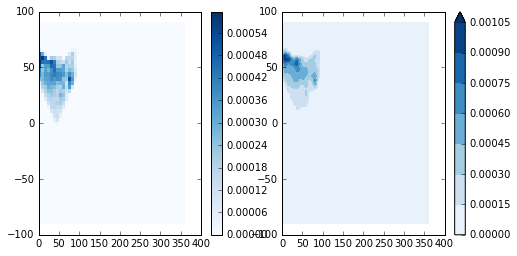

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

P_random.pos_kde = None

start = time.time()
print "start time:", start

P_random.get_sigma_pos(np.array([1.0, 2.0]), np.array([1.0, -1.0]), catalog=tgas_full)

print "Build tree:", time.time()-start, "seconds"
start = time.time()

nbins = 50
xmin, xmax = 0.0, 360.0
ymin, ymax = -90.0, 90.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T


pdf, xedges, yedges = np.histogram2d(tgas_full['ra'], 
                                     tgas_full['dec'],
                                     normed=True,
                                     bins=[xbins,ybins])
im = ax[0].pcolormesh(xbins, ybins, pdf.T, cmap='Blues')
fig.colorbar(im, ax=ax[0])

print "Histogram:", time.time()-start, "seconds"
start = time.time()

                                     
                                     
Z = P_random.get_sigma_pos(X.flatten(), Y.flatten(), catalog=tgas_full)
im = ax[1].tricontourf(mu_grid[:,0], mu_grid[:,1], Z, cmap='Blues', extend='max')
fig.colorbar(im, ax=ax[1])

print "Default gaussian_kde:", time.time()-start, "seconds"
start = time.time()



plt.show()

### Let's calculate the overall number of stellar pairs

In [171]:
n_set = 10**np.linspace(2, 5, 10)
factor = np.zeros(10)

for i, num_sys in zip(np.arange(10), n_set):

    print i, num_sys
    
    # Monte Carlo select random positions
    ran_theta = np.arccos(1.0-2.0*np.random.uniform(size = num_sys))
    ran_phi = 2.0 * np.pi * np.random.uniform(size = num_sys)

    ran_dec = (ran_theta-np.pi/2.0) * 180.0/np.pi
    ran_ra = ran_phi * 180.0/np.pi

    # Calculate sigma^2
    sigma_pos = P_random.get_sigma_pos(ran_ra, ran_dec, catalog=tgas_full)
    sigma_pos_2 = sigma_pos**2

    
    factor[i] = np.mean(sigma_pos_2)
    
    
n_square_degrees = 41253.

plt.plot(n_set, n_square_degrees/(2.0*factor))
plt.xscale('log')

plt.show()

0 100.0
1 215.443469003
2 464.158883361
3 1000.0
4 2154.43469003
5 4641.58883361
6 10000.0
7 21544.3469003
8 46415.8883361
9 100000.0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Demonstrate the difference between a true pair vs. a false pair

In [3]:
P_binary.binary_kde = None

num_sys = 10000
P_binary.generate_binary_set(num_sys=num_sys)
mu_set = np.array([np.log10(P_binary.binary_set['proj_sep']), np.log10(P_binary.binary_set['delta_v_trans'])]).T

P_binary.get_P_binary(np.array([1.0, 1.0]), np.array([1.0, 0.9]))

array([ 0.,  0.])

In [4]:
fontProperties = {'family':'serif', 'serif':['Times New Roman'], 'weight':'normal', 'size':12}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal', \
                                         weight='normal', stretch='normal', size=10)
plt.rc('font', **fontProperties)



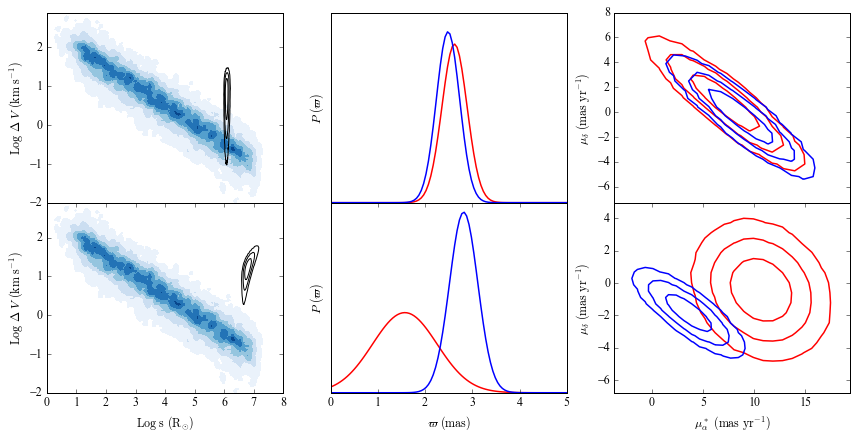

In [11]:
def get_random_samples(id1, t, n_samples):

    # Create astrometry vectors
    star1_mean = np.array([t['mu_ra'][id1], t['mu_dec'][id1], t['plx'][id1]])
    
    # Create covariance matrices
    star1_cov = np.array([[t['mu_ra_err'][id1]**2, t['mu_ra_mu_dec_cov'][id1], t['mu_ra_plx_cov'][id1]], \
                   [t['mu_ra_mu_dec_cov'][id1], t['mu_dec_err'][id1]**2, t['mu_dec_plx_cov'][id1]], \
                   [t['mu_ra_plx_cov'][id1], t['mu_dec_plx_cov'][id1], t['plx_err'][id1]**2]])
    
    # Create multivariate_normal objects
    star1_astrometry = multivariate_normal(mean=star1_mean, cov=star1_cov)

    
    return star1_astrometry.rvs(size=n_samples)



def generate_proper_motion_plot(mu_ra, mu_dec, ax, nbins_x=20, nbins_y=20, color='k'):
    
    H, xedges, yedges = np.histogram2d(mu_ra, mu_dec, bins=(nbins_x,nbins_y), normed=True)

    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.683))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.954))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.9973))
    levels = [one_sigma, two_sigma, three_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    contour = ax.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color, linewidth=1.5)
    zc = contour.collections
    plt.setp(zc, linewidth=1.5)


def generate_s_dV_contours(proj_sep, delta_v_trans, nbins_x, nbins_y, ax, color='k'):

    H, xedges, yedges = np.histogram2d(np.log10(proj_sep), np.log10(delta_v_trans), bins=(nbins_x,nbins_y), normed=True)

    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.683))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.954))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.9973))
    levels = [three_sigma, two_sigma, one_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    contour = ax.contour(X, Y, Z, levels=levels, origin="lower", colors=[color])


    
# Need this function
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level




# Set the catalog, t
t = tgas_full


fig, ax = plt.subplots(2, 3, figsize=(12,6))





# P_binary contours
nbins = 100
xmin, xmax = 0.0, 8.0
ymin, ymax = -2.0, 3.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T

Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten())
Z = Z * 10**X.flatten() * 10**Y.flatten() * np.log(10.)**2

levels = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
im = ax[0,0].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels)
im = ax[1,0].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels)



size_integrate_full = 1000000




# Good match
id1 = 28360
id2 = 28361

star1_samples = get_random_samples(id1, tgas_full, size_integrate_full)
star2_samples = get_random_samples(id2, tgas_full, size_integrate_full)


# Create contours
theta = P_random.get_theta_proj_degree(tgas_full['ra'][id1], tgas_full['dec'][id1], tgas_full['ra'][id2], tgas_full['dec'][id2])
dist_sample = 1.0e3 / (0.5*(star1_samples.T[2]+star2_samples.T[2]))  # convert from mas to asec
delta_mu_sample = np.sqrt((star1_samples.T[0]-star2_samples.T[0])**2 +(star1_samples.T[1]-star2_samples.T[1])**2)
delta_v_trans = (delta_mu_sample/1.0e3/3600.0*np.pi/180.0) * dist_sample * (c.pc_to_cm/1.0e5) / (c.yr_to_sec)
proj_sep = (theta*np.pi/180.0) * dist_sample * (c.pc_to_cm / c.Rsun_to_cm)
generate_s_dV_contours(proj_sep, delta_v_trans, 50, 50, ax[0,0], color='k')



# Parallax
a, b = (0.0 - t['plx'][id1]) / t['plx_err'][id1], (10.0 - t['plx'][id1]) / t['plx_err'][id1]
ran_plx_1_x = np.linspace(0.0, 5.0, 100)
ran_plx_1_y = truncnorm.pdf(ran_plx_1_x, a, b, loc=t['plx'][id1], scale=t['plx_err'][id1])
a, b = (0.0 - t['plx'][id2]) / t['plx_err'][id2], (10.0 - t['plx'][id2]) / t['plx_err'][id2]
ran_plx_2_x = np.linspace(0.0, 5.0, 100)
ran_plx_2_y = truncnorm.pdf(ran_plx_1_x, a, b, loc=t['plx'][id2], scale=t['plx_err'][id2])
ax[0,1].plot(ran_plx_1_x, ran_plx_1_y, color='r', linewidth=1.5)
ax[0,1].plot(ran_plx_2_x, ran_plx_2_y, color='b', linewidth=1.5)

# Proper motion
generate_proper_motion_plot(star1_samples.T[0], star1_samples.T[1], ax[0,2], color='r')
generate_proper_motion_plot(star2_samples.T[0], star2_samples.T[1], ax[0,2], color='b')




# Bad match
id1 = 21212
id2 = 21213

star1_samples = get_random_samples(id1, tgas_full, size_integrate_full)
star2_samples = get_random_samples(id2, tgas_full, size_integrate_full)

# Create contours
theta = P_random.get_theta_proj_degree(tgas_full['ra'][id1], tgas_full['dec'][id1], tgas_full['ra'][id2], tgas_full['dec'][id2])
dist_sample = 1.0e3 / (0.5*(star1_samples.T[2]+star2_samples.T[2]))  # convert from mas to asec
delta_mu_sample = np.sqrt((star1_samples.T[0]-star2_samples.T[0])**2 +(star1_samples.T[1]-star2_samples.T[1])**2)
delta_v_trans = (delta_mu_sample/1.0e3/3600.0*np.pi/180.0) * dist_sample * (c.pc_to_cm/1.0e5) / (c.yr_to_sec)
proj_sep = (theta*np.pi/180.0) * dist_sample * (c.pc_to_cm / c.Rsun_to_cm)
generate_s_dV_contours(proj_sep, delta_v_trans, 50, 50, ax[1,0], color='k')


# Parallax
a, b = (0.0 - t['plx'][id1]) / t['plx_err'][id1], (10.0 - t['plx'][id1]) / t['plx_err'][id1]
ran_plx_1_x = np.linspace(0.0, 5.0, 100)
ran_plx_1_y = truncnorm.pdf(ran_plx_1_x, a, b, loc=t['plx'][id1], scale=t['plx_err'][id1])
a, b = (0.0 - t['plx'][id2]) / t['plx_err'][id2], (10.0 - t['plx'][id2]) / t['plx_err'][id2]
ran_plx_2_x = np.linspace(0.0, 5.0, 100)
ran_plx_2_y = truncnorm.pdf(ran_plx_1_x, a, b, loc=t['plx'][id2], scale=t['plx_err'][id2])
ax[1,1].plot(ran_plx_1_x, ran_plx_1_y, color='r', linewidth=1.5)
ax[1,1].plot(ran_plx_2_x, ran_plx_2_y, color='b', linewidth=1.5)

# Proper motion
generate_proper_motion_plot(star1_samples.T[0], star1_samples.T[1], ax[1,2], color='r')
generate_proper_motion_plot(star2_samples.T[0], star2_samples.T[1], ax[1,2], color='b')








ax[0,0].set_xlim(0,8)
ax[0,0].set_ylim(-2.0,2.9)
ax[1,0].set_xlim(0,8)
ax[1,0].set_ylim(-2.0,2.9)

ax[1,0].set_xlabel(r'${\rm Log\ s}\ ({\rm R}_{\odot})$')
ax[0,0].set_ylabel(r'${\rm Log}\ \Delta\ V\ ({\rm km\ s}^{-1})$')
ax[1,0].set_ylabel(r'${\rm Log}\ \Delta\ V\ ({\rm km\ s}^{-1})$')

ax[1,1].set_xlabel(r'$\varpi\ ({\rm mas})$')
ax[0,1].set_ylabel(r'$P\ (\varpi)$')
ax[1,1].set_ylabel(r'$P\ (\varpi)$')


ax[1,2].set_xlabel(r'$\mu^*_{\alpha}\ ({\rm mas\ yr}^{-1})$')
ax[0,2].set_ylabel(r'$\mu_{\delta}\ ({\rm mas\ yr}^{-1})$')
ax[1,2].set_ylabel(r'$\mu_{\delta}\ ({\rm mas\ yr}^{-1})$')

ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])


fig.subplots_adjust(bottom=0.09, left=0.05, right=.98, top=.97, hspace=0.0, wspace=0.20)

plt.savefig('../figures/Examples_s_dV.pdf')
#plt.show()

### Now, let's make a similar plot, comparing Gaia's sensitivity to the binary star delta V distribution

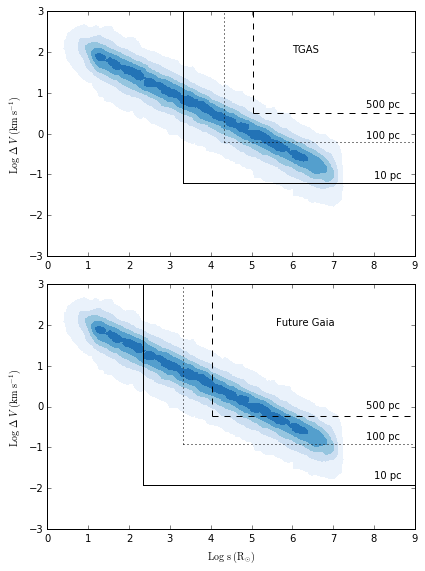

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(6,8))



nbins = 100
xmin, xmax = 0.0, 9.0
ymin, ymax = -3.0, 3.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T

Z = P_binary.get_P_binary(10**X.flatten(), 10**Y.flatten())
Z = Z * 10**X.flatten() * 10**Y.flatten() * np.log(10.)**2

levels = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
im = ax[0].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels)

#ax[0].set_xlabel(r'${\rm Log\ s}\ ({\rm R}_{\odot})$')
ax[0].set_ylabel(r'${\rm Log}\ \Delta\ V\ ({\rm km\ s}^{-1})$')



sigma_pm = 1.32 # mas/yr
theta_lim = 1.0 # asec
delta_v_lim_500pc = sigma_pm * 1.0/(1.0e3*3600.0*180.0/np.pi) * (500.0*c.pc_to_cm/1.0e5) * 1.0/c.yr_to_sec
s_lim_500pc = theta_lim * 1.0/(3600.0*180.0/np.pi) * (500.0*c.pc_to_cm/c.Rsun_to_cm)
delta_v_lim_100pc = sigma_pm * 1.0/(1.0e3*3600.0*180.0/np.pi) * (100.0*c.pc_to_cm/1.0e5) * 1.0/c.yr_to_sec
s_lim_100pc = theta_lim * 1.0/(3600.0*180.0/np.pi) * (100.0*c.pc_to_cm/c.Rsun_to_cm)
delta_v_lim_10pc = sigma_pm * 1.0/(1.0e3*3600.0*180.0/np.pi) * (10.0*c.pc_to_cm/1.0e5) * 1.0/c.yr_to_sec
s_lim_10pc = theta_lim * 1.0/(3600.0*180.0/np.pi) * (10.0*c.pc_to_cm/c.Rsun_to_cm)


ax[0].plot([np.log10(s_lim_500pc),xmax], [np.log10(delta_v_lim_500pc), np.log10(delta_v_lim_500pc)], 
           color='k', linestyle='dashed')
ax[0].plot([np.log10(s_lim_500pc),np.log10(s_lim_500pc)], [np.log10(delta_v_lim_500pc), ymax], 
           color='k', linestyle='dashed')

ax[0].plot([np.log10(s_lim_100pc),xmax], [np.log10(delta_v_lim_100pc), np.log10(delta_v_lim_100pc)], 
           color='k', linestyle='dotted')
ax[0].plot([np.log10(s_lim_100pc),np.log10(s_lim_100pc)], [np.log10(delta_v_lim_100pc), ymax], 
           color='k', linestyle='dotted')

ax[0].plot([np.log10(s_lim_10pc),xmax], [np.log10(delta_v_lim_10pc), np.log10(delta_v_lim_10pc)], 
           color='k', linestyle='solid')
ax[0].plot([np.log10(s_lim_10pc),np.log10(s_lim_10pc)], [np.log10(delta_v_lim_10pc), ymax], 
           color='k', linestyle='solid')


ax[0].text(7.8, 0.65, '500 pc')
ax[0].text(7.8, -0.1, '100 pc')
ax[0].text(8.0, -1.1, '10 pc')

ax[0].text(6.0, 2.0, "TGAS")



im = ax[1].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels)

ax[1].set_xlabel(r'${\rm Log\ s}\ ({\rm R}_{\odot})$')
ax[1].set_ylabel(r'${\rm Log}\ \Delta\ V\ ({\rm km\ s}^{-1})$')

sigma_pm = 0.25 # mas/yr
theta_lim = 0.1 # asec From on-ground processing (Harrison 2011)
delta_v_lim_500pc = sigma_pm * 1.0/(1.0e3*3600.0*180.0/np.pi) * (500.0*c.pc_to_cm/1.0e5) * 1.0/c.yr_to_sec
s_lim_500pc = theta_lim * 1.0/(3600.0*180.0/np.pi) * (500.0*c.pc_to_cm/c.Rsun_to_cm)
delta_v_lim_100pc = sigma_pm * 1.0/(1.0e3*3600.0*180.0/np.pi) * (100.0*c.pc_to_cm/1.0e5) * 1.0/c.yr_to_sec
s_lim_100pc = theta_lim * 1.0/(3600.0*180.0/np.pi) * (100.0*c.pc_to_cm/c.Rsun_to_cm)
delta_v_lim_10pc = sigma_pm * 1.0/(1.0e3*3600.0*180.0/np.pi) * (10.0*c.pc_to_cm/1.0e5) * 1.0/c.yr_to_sec
s_lim_10pc = theta_lim * 1.0/(3600.0*180.0/np.pi) * (10.0*c.pc_to_cm/c.Rsun_to_cm)


ax[1].plot([np.log10(s_lim_500pc),xmax], [np.log10(delta_v_lim_500pc), np.log10(delta_v_lim_500pc)], 
           color='k', linestyle='dashed')
ax[1].plot([np.log10(s_lim_500pc),np.log10(s_lim_500pc)], [np.log10(delta_v_lim_500pc), ymax], 
           color='k', linestyle='dashed')

ax[1].plot([np.log10(s_lim_100pc),xmax], [np.log10(delta_v_lim_100pc), np.log10(delta_v_lim_100pc)], 
           color='k', linestyle='dotted')
ax[1].plot([np.log10(s_lim_100pc),np.log10(s_lim_100pc)], [np.log10(delta_v_lim_100pc), ymax], 
           color='k', linestyle='dotted')

ax[1].plot([np.log10(s_lim_10pc),xmax], [np.log10(delta_v_lim_10pc), np.log10(delta_v_lim_10pc)], 
           color='k', linestyle='solid')
ax[1].plot([np.log10(s_lim_10pc),np.log10(s_lim_10pc)], [np.log10(delta_v_lim_10pc), ymax], 
           color='k', linestyle='solid')




ax[1].text(7.8, -0.05, '500 pc')
ax[1].text(7.8, -0.8, '100 pc')
ax[1].text(8.0, -1.75, '10 pc')

ax[1].text(5.6, 2.0, "Future Gaia")


fig.subplots_adjust(wspace=0)

plt.tight_layout()
plt.savefig('../figures/Gaia_s_dV_limits.pdf')
#plt.show()


In [214]:
import parallax
from scipy.stats import norm
import corner

parallax.plx_kde = None
parallax.set_plx_kde(t)

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Library/Python/2.7/site-

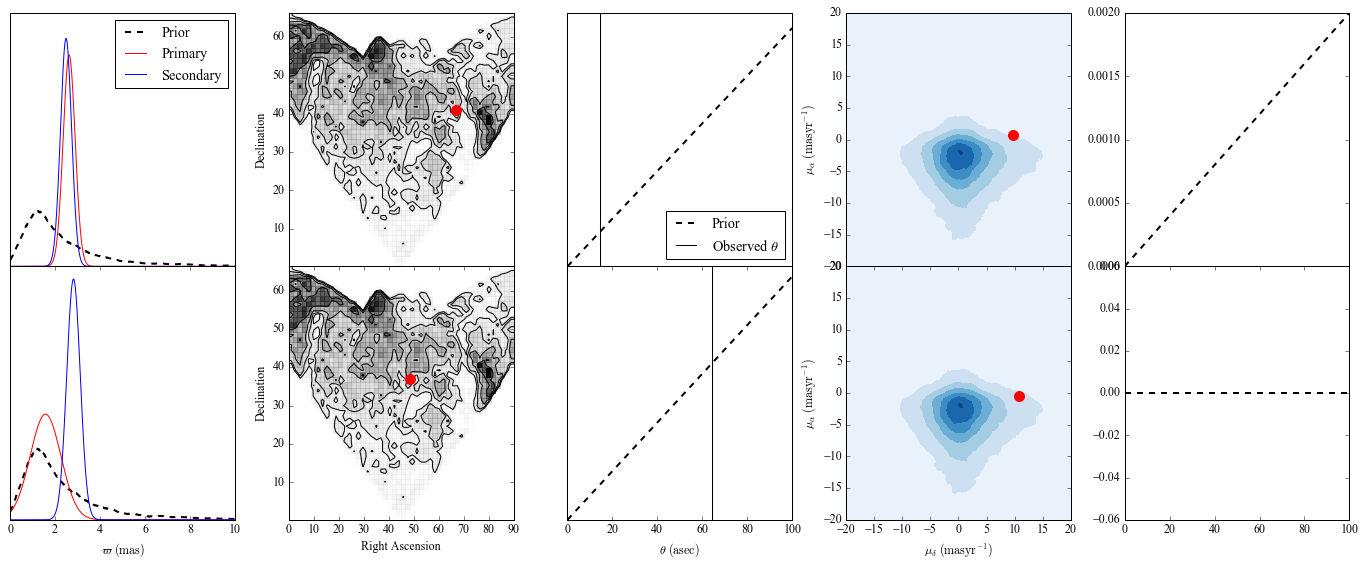

In [246]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))



# PARALLAX
tmp_x = np.linspace(0.0001, 10, 1000)
P_plx = parallax.get_plx_prior(tmp_x)

# Good match
id1 = 28360
id2 = 28361
plx_1 = norm.pdf(tmp_x, loc=t['plx'][id1], scale=t['plx_err'][id1])
plx_2 = norm.pdf(tmp_x, loc=t['plx'][id2], scale=t['plx_err'][id2])
ax[0,0].plot(tmp_x, P_plx, color='k', linewidth=2.0, linestyle='dashed', label="Prior")
ax[0,0].plot(tmp_x, plx_1, color='r', label='Primary')
ax[0,0].plot(tmp_x, plx_2, color='b', label='Secondary')
ax[0,0].set_yticks([])
ax[0,0].set_xticks([])
ax[0,0].legend()

# Bad match
id1 = 21212
id2 = 21213
plx_1 = norm.pdf(tmp_x, loc=t['plx'][id1], scale=t['plx_err'][id1])
plx_2 = norm.pdf(tmp_x, loc=t['plx'][id2], scale=t['plx_err'][id2])
ax[1,0].plot(tmp_x, P_plx, color='k', linewidth=2.0, linestyle='dashed')
ax[1,0].plot(tmp_x, plx_1, color='r')
ax[1,0].plot(tmp_x, plx_2, color='b')
ax[1,0].set_yticks([])
ax[1,0].set_xlabel(r'$\varpi\ ({\rm mas})$')





# POSITION - 1
id1 = 28360
id2 = 28361
corner.hist2d(t['ra'], t['dec'], bins=50, plot_datapoints=False, ax=ax[0,1])
ax[0,1].scatter(t['ra'][id1], t['dec'][id1], color='r', s=100, zorder=10)
ax[0,1].set_xticks([])
ax[0,1].set_xlabel('Right Ascension')
ax[0,1].set_ylabel('Declination')

id1 = 21212
id2 = 21213
corner.hist2d(t['ra'], t['dec'], bins=50, plot_datapoints=False, ax=ax[1,1])
ax[1,1].scatter(t['ra'][id1], t['dec'][id1], color='r', s=100, zorder=10)
ax[1,1].set_xlabel('Right Ascension')
ax[1,1].set_ylabel('Declination')



# POSITION - 2
id1 = 28360
id2 = 28361
tmp_x = np.linspace(0.0001, 100.0, 100)
pos_density = P_random.get_sigma_pos(t['ra'][id1], t['dec'][id1], catalog=t)
ax[0,2].plot(tmp_x, 2.0*np.pi*tmp_x*pos_density, color='k', linestyle='dashed', linewidth=2.0, label='Prior')
theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2])*3600.0
ax[0,2].axvline(theta, color='k', label=r'Observed $\theta$')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[0,2].legend(loc=4)


id1 = 21212
id2 = 21213
tmp_x = np.linspace(0.0001, 100.0, 100)
pos_density = P_random.get_sigma_pos(t['ra'][id1], t['dec'][id1], catalog=t)
ax[1,2].plot(tmp_x, 2.0*np.pi*tmp_x*pos_density, color='k', linestyle='dashed', linewidth=2.0)
theta = P_random.get_theta_proj_degree(t['ra'][id1], t['dec'][id1], t['ra'][id2], t['dec'][id2]) * 3600.0
ax[1,2].set_xlabel(r'$\theta\ ({\rm asec})$')
ax[1,2].axvline(theta, color='k')
ax[1,2].set_yticks([])



# PROPER MOTION - 1 
nbins = 100
xmin, xmax = -20.0, 20.0
ymin, ymax = -20.0, 20.0

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(xbins, ybins)
mu_grid = np.array([X.flatten(), Y.flatten()]).T
Z = P_random.get_sigma_mu(X.flatten(), Y.flatten(), catalog=t)
im = ax[0,3].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues')
im = ax[1,3].tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues')

id1 = 28360
id2 = 28361
ax[0,3].scatter(t['mu_ra'][id1], t['mu_dec'][id1], color='r', s=100, zorder=10)
ax[0,3].set_xticks([])
ax[0,3].set_ylabel(r'$\mu_{\alpha}\ ({\rm mas yr}^{-1})$')
ax[0,3].set_xlim(-20.0, 20.0)
ax[0,3].set_ylim(-20.0, 20.0)

id1 = 21212
id2 = 21213
ax[1,3].scatter(t['mu_ra'][id1], t['mu_dec'][id1], color='r', s=100, zorder=10)
ax[1,3].set_ylabel(r'$\mu_{\alpha}\ ({\rm mas yr}^{-1})$')
ax[1,3].set_xlabel(r'$\mu_{\delta}\ ({\rm mas yr}^{-1})$')
ax[1,3].set_xlim(-20.0, 20.0)
ax[1,3].set_ylim(-20.0, 20.0)



# PROPER MOTION - 2 
id1 = 28360
id2 = 28361
tmp_x = np.linspace(0.0001, 100.0, 100)
pm_density = P_random.get_sigma_pos(t['mu_ra'][id1], t['mu_dec'][id1], catalog=t)
ax[0,4].plot(tmp_x, 2.0*np.pi*tmp_x*pm_density, color='k', linestyle='dashed', linewidth=2.0)
ax[0,4].set_xticks([])


id1 = 21212
id2 = 21213
tmp_x = np.linspace(0.0001, 100.0, 100)
pm_density = P_random.get_sigma_pos(t['mu_ra'][id1], t['mu_dec'][id1], catalog=t)
ax[1,4].plot(tmp_x, 2.0*np.pi*tmp_x*pm_density, color='k', linestyle='dashed', linewidth=2.0)









fig.subplots_adjust(bottom=0.09, left=0.05, right=.98, top=.97, hspace=0.0, wspace=0.24)

plt.savefig('../figures/Examples_random_alignment.pdf')
#plt.show()